In [1]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
import moviepy.editor as mp
import scipy.misc
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# Check devices
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())


In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [11]:
CWD_PATH = os.getcwd()
#RELEASE_PATH = '/home/data/00_release/01_vehicles'
RELEASE_PATH = '/home/data/10_working/00_graph/01_vehicles'
#RELEASE_DATE = '20181130'
#RELEASE_DATE = '20181203'
#RELEASE_DATE = '20181228'
#RELEASE_DATE = '20190131'
#RELEASE_DATE = '20190328'
#RELEASE_DATE = '20190503'
RELEASE_DATE = '20190508'
RESOLUTION = '160x90'
#RESOLUTION = '320x180'
#RESOLUTION = '1280x720'
#RESOLUTION = '1920x1080'
#RESOLUTION = 'c320x200'
#RESOLUTION = 'c1920x1200'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_SSDLITE_MOBILENET_V2 = 'ssdlite_mobilenet_v2'
MODEL_SSD_MOBILENET_V2 = 'ssd_mobilenet_v2'
MODEL_SSD_MOBILENET_V1 = 'ssd_mobilenet_v1'
MODEL_SSD_INCEPTION_V2 = 'ssd_inception_v2'
MODEL_FASTER_RCNN_INCEPTION_V2 = 'faster_rcnn_inception_v2'
MODEL_FASTER_RCNN_RESNET50 = 'faster_rcnn_resnet50'
MODEL_FASTER_RCNN_RESNET101 = 'faster_rcnn_resnet101'
MODEL_RFCN_RESNET101 = 'rfcn_resnet101'

MODEL_NAME = MODEL_SSD_MOBILENET_V2

#FPS = 10 # faster_rcnn_inception_v2, rfcn_resnet101
FPS = 20 # ssdlite_mobilenet_v2, ssd_mobilenet_v2, ssd_inception_v2

MIN_SCORE_THRESH = 0.5

#PATH_TO_CKPT = os.path.join(CWD_PATH, 'object_detection', MODEL_NAME, 'frozen_inference_graph.pb')
#PATH_TO_CKPT = os.path.join(RELEASE_PATH, RELEASE_DATE, MODEL_NAME, 'frozen_inference_graph.pb')
#PATH_TO_CKPT = os.path.join(RELEASE_PATH, RELEASE_DATE, MODEL_NAME, 'frozen/frozen_inference_graph.pb')
PATH_TO_CKPT = os.path.join(RELEASE_PATH, RELEASE_DATE, '3classes', MODEL_NAME, 'frozen/frozen_inference_graph.pb')

print('PATH_TO_CKPT: ', PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
#PATH_TO_LABELS = os.path.join('kitti', 'kitti_label_map.pbtxt')
#PATH_TO_LABELS = os.path.join(CWD_PATH, 'object_detection', 'training', 'data', 'object-detection.pbtxt')
PATH_TO_LABELS = os.path.join(RELEASE_PATH, RELEASE_DATE, '3classes', MODEL_NAME, 'object-detection.pbtxt')
print('PATH_TO_LABELS: ', PATH_TO_LABELS)

# process images path
PROCESS_IMAGES_PATH = os.path.join(CWD_PATH, 'test_images', 'output', MODEL_NAME, RESOLUTION)

# ground-truth image path
GROUNDTRUTH_PROVIDER = 'full' # 'deepdrive'
#GROUNDTRUTH_PROVIDER = '3classes' # 'deepdrive'


PATH_TO_CKPT:  /home/data/10_working/00_graph/01_vehicles/20190508/3classes/ssd_mobilenet_v2/frozen/frozen_inference_graph.pb
PATH_TO_LABELS:  /home/data/10_working/00_graph/01_vehicles/20190508/3classes/ssd_mobilenet_v2/object-detection.pbtxt


In [12]:
NUM_CLASSES = 3

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

print(label_map)

item {
  name: "car"
  id: 1
}
item {
  name: "truck"
  id: 2
}
item {
  name: "bus"
  id: 3
}



In [13]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
def detect_objects(image_np, sess, detection_graph, min_score_thresh=0.5, line_thickness=2, skip_scores=False, skip_labels=False):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
   
    taco = [category_index.get(value) for index,value in enumerate(classes[0]) if scores[0,index] > min_score_thresh]
    #print(len(taco))
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        min_score_thresh=min_score_thresh,
        line_thickness=line_thickness,
        skip_scores=skip_scores,
        skip_labels=skip_labels,
        use_normalized_coordinates=True)
    return image_np, len(taco)

In [14]:
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

#TEST_IMAGES_PATH = os.path.join(CWD_PATH, 'test_images')
#TEST_IMAGES_PATH = os.path.join(CWD_PATH, 'test_images', RESOLUTION)
TEST_IMAGES_PATH = os.path.join(CWD_PATH, 'test_images', 'gt', GROUNDTRUTH_PROVIDER, 'images')
IMAGES_LIST = os.listdir(TEST_IMAGES_PATH)
IMAGES_LIST.sort()

print(TEST_IMAGES_PATH)

/home/workspace/learning/tensorflow/models/research/test_images/gt/full/images


0 /home/workspace/learning/tensorflow/models/research/test_images/gt/full/images/000022.png (1242, 375) (375, 1242, 3)
375 1242
10 /home/workspace/learning/tensorflow/models/research/test_images/gt/full/images/001859.png (1242, 375) (375, 1242, 3)
375 1242
20 /home/workspace/learning/tensorflow/models/research/test_images/gt/full/images/004288.png (1241, 376) (376, 1241, 3)
376 1241
30 /home/workspace/learning/tensorflow/models/research/test_images/gt/full/images/006349.png (1242, 375) (375, 1242, 3)
375 1242
40 /home/workspace/learning/tensorflow/models/research/test_images/gt/full/images/1478020508699163524.jpg (1920, 1200) (1200, 1920, 3)
1200 1920


KeyboardInterrupt: 

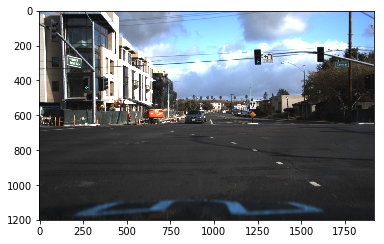

In [9]:
for idx, item in enumerate(IMAGES_LIST):
    image_path = os.path.join(TEST_IMAGES_PATH, item)
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    if idx % 10 == 0:
        print(idx, image_path, image.size, image_np.shape)
        #print(image_np.shape[0], image_np.shape[1])
        plt.imshow(image_np)


In [15]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

[  30/ 300] image processing
[  60/ 300] image processing
[  90/ 300] image processing
[ 120/ 300] image processing
[ 150/ 300] image processing
[ 180/ 300] image processing
[ 210/ 300] image processing
[ 240/ 300] image processing
[ 270/ 300] image processing
[ 300/ 300] image processing
initial time: 788.46
total image count:  300
total detect count:  1874
average detect time: 29.24
average detect count: 6.27
average no detect time: 13.48, image count: 3
every each other object detect time: 2.51


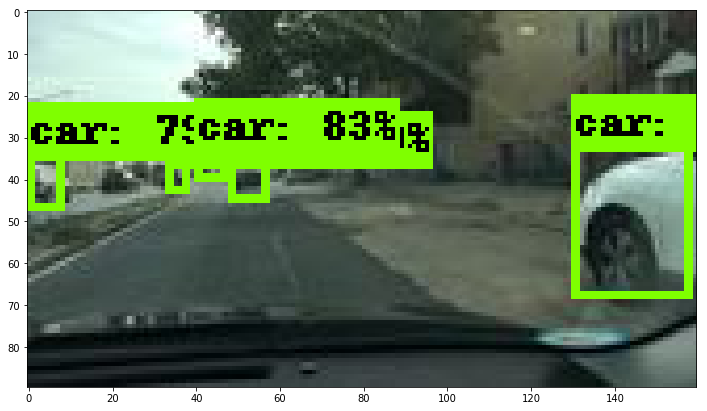

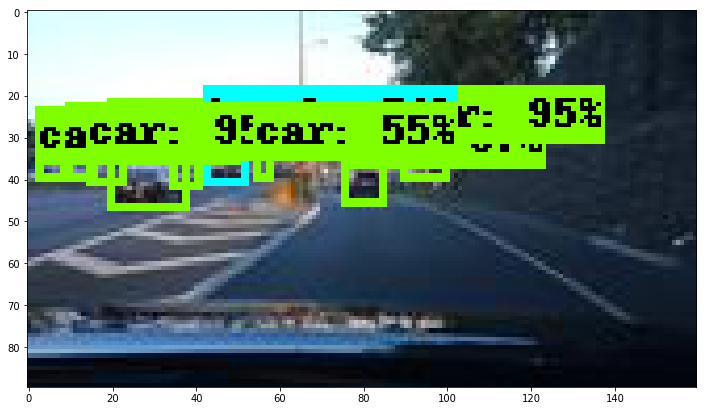

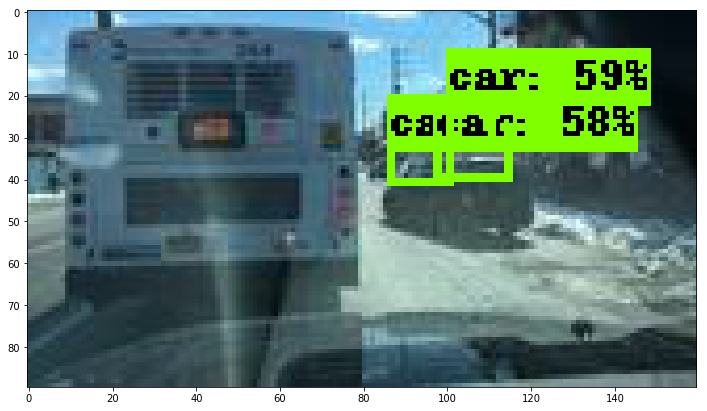

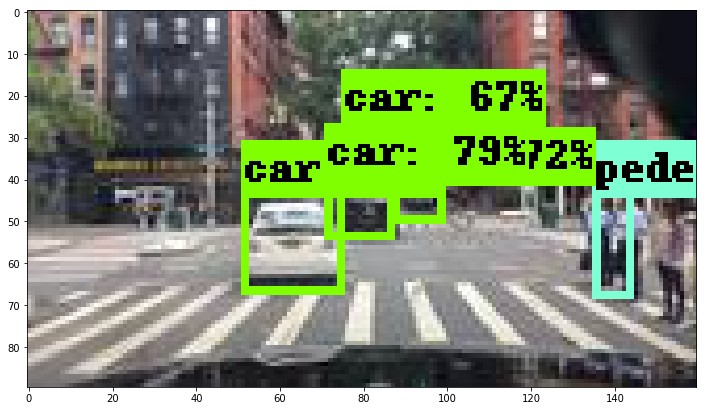

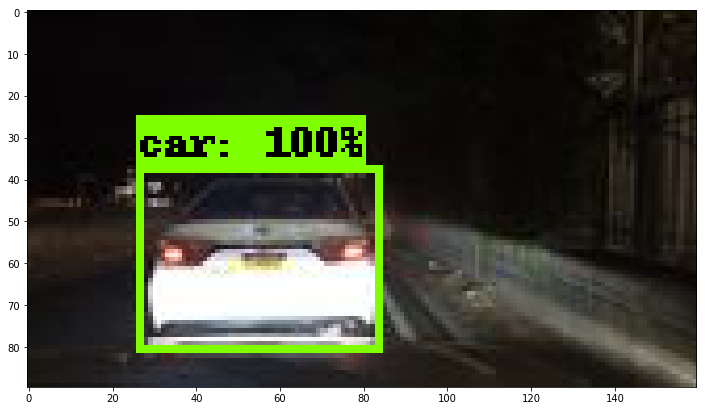

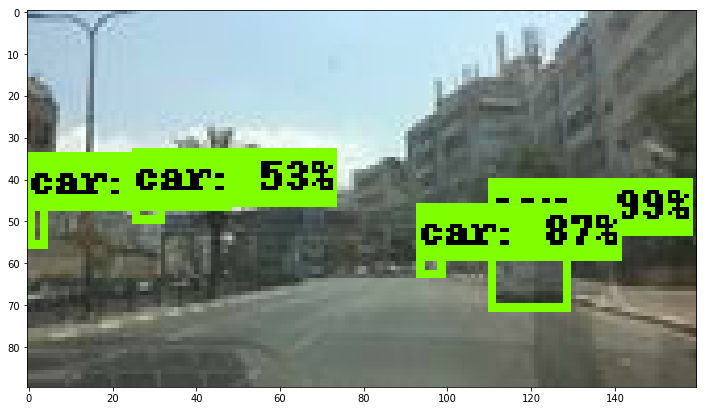

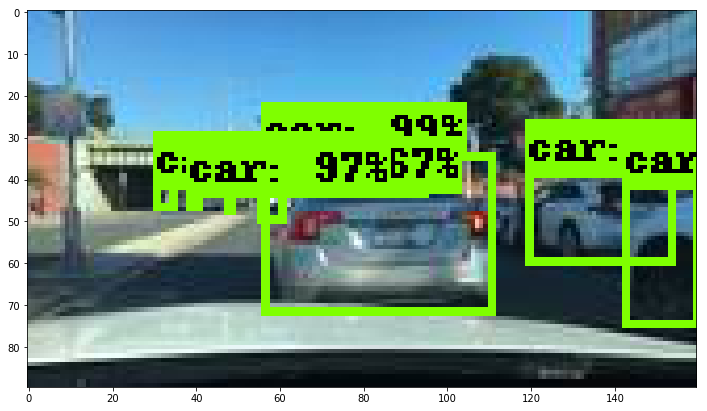

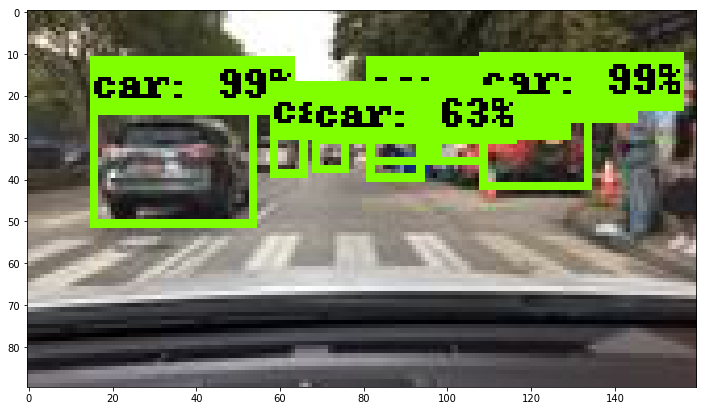

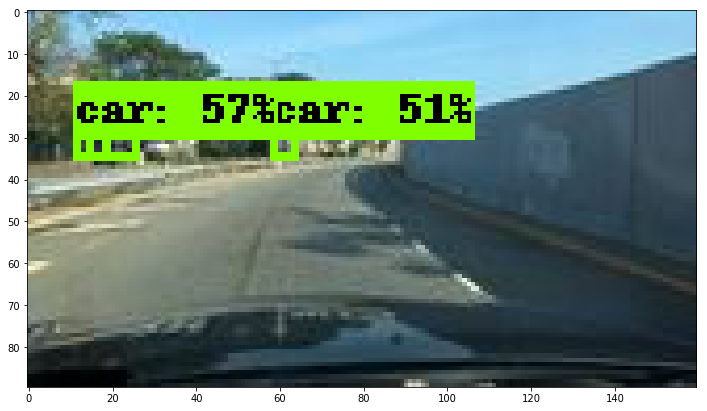

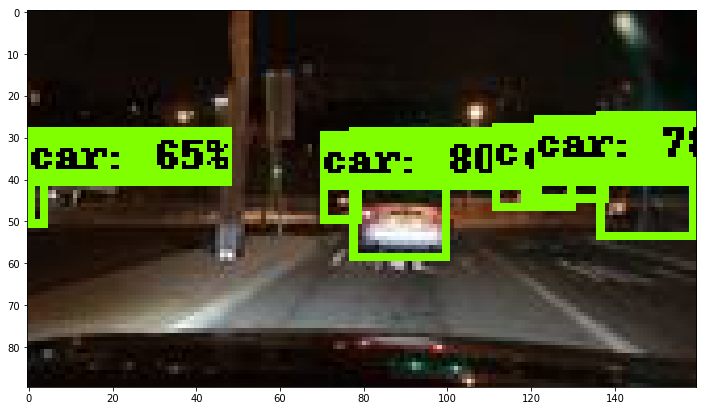

In [23]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        initial_time = 0
        total_time = 0
        total_count = 0
        no_detect_count = 0
        no_detect_time = 0
        average_time = 0
        average_count = 0
        average_no_detect_time = 0
        one_object_detect_time = 0
        line_thickness = 2
        skip_scores = False
        skip_labels = False
        
        if RESOLUTION == 'c320x200' or RESOLUTION == '320x180':
            line_thickness = 1
            skip_scores = True
            skip_labels = True
        
        if not os.path.isdir(PROCESS_IMAGES_PATH):
            os.makedirs(PROCESS_IMAGES_PATH)
    
        for idx, item in enumerate(IMAGES_LIST, 1):
            image_path = os.path.join(TEST_IMAGES_PATH, item)
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            start_time = time.time()
            image_process, count = detect_objects(image_np, sess, detection_graph, 
                                                  MIN_SCORE_THRESH, line_thickness, skip_scores, skip_labels)
            elapsed_time = time.time() - start_time
            
            output_image_file = os.path.join(PROCESS_IMAGES_PATH, item)
            #output_image = Image.fromarray(image_process)
            #output_image.save(output_image_file)
            scipy.misc.imsave(output_image_file, image_process)

            if idx == 1:
                initial_time = elapsed_time
            else: # idx > 1:
                total_time += elapsed_time
                total_count += count
                if count == 0:
                    no_detect_count += 1
                    no_detect_time += elapsed_time
            if idx % (len(IMAGES_LIST) / 10) == 0:
                print('[{0:4d}/{1:4d}] image processing'.format(idx, len(IMAGES_LIST)))
                #print('[', idx, '/', len(IMAGES_LIST), '] ', elapsed_time, count, image_process.shape)
                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_process)
                #print(idx, image_path, image.size, image_np.shape)
                #plt.imshow(image_np)

        average_time = total_time / (len(IMAGES_LIST) - 1)
        average_count = total_count / (len(IMAGES_LIST) - 1)
        if no_detect_count != 0: 
            average_no_detect_time = no_detect_time / no_detect_count
        one_object_detect_time = (average_time - average_no_detect_time) / average_count

        print('initial time: {0:.2f}'.format(initial_time * 1000))
        print('total image count: ', len(IMAGES_LIST))
        print('total detect count: ', total_count)
        print('average detect time: {0:.2f}'.format(average_time * 1000))
        print('average detect count: {0:.2f}'.format(average_count))
        print('average no detect time: {0:.2f}, image count: {1}'.format(average_no_detect_time * 1000, no_detect_count))
        print('every each other object detect time: {0:.2f}'.format(one_object_detect_time * 1000))



In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process, _ = detect_objects(image, sess, detection_graph, min_score_thresh=MIN_SCORE_THRESH)
            return image_process

In [14]:
#VIDEO_FILE = 'test_video_02.mp4'
VIDEO_FILE = 'demoVideo.mp4'
VIDEO_PATH = '/home/data/video'
VIDEO_OUTPUT_PATH = os.path.join(VIDEO_PATH, 'output', RELEASE_DATE, MODEL_NAME)

VIDEO_INPUT_FILE = os.path.join(VIDEO_PATH, VIDEO_FILE)
#VIDEO_OUTPUT_FILE = os.path.join(VIDEO_OUTPUT_PATH, VIDEO_FILE)
VIDEO_OUTPUT_FILE = os.path.join(VIDEO_OUTPUT_PATH, 'demoVideo_70.mp4')

print(VIDEO_INPUT_FILE)
print(VIDEO_OUTPUT_FILE)

if not os.path.isdir(VIDEO_OUTPUT_PATH):
    os.makedirs(VIDEO_OUTPUT_PATH)

clip = mp.VideoFileClip(VIDEO_INPUT_FILE).subclip(60,100)
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
text_clip = mp.TextClip(MODEL_NAME, color='white', fontsize=60, font='Amiri-Bold').set_pos(('center', 'bottom'))
final = mp.CompositeVideoClip([new_clip, text_clip])

%time final.set_duration(new_clip.duration).write_videofile(VIDEO_OUTPUT_FILE, fps=FPS, audio=False)
'''
VIDEO_PATH = '/home/data/video'
VIDEO_INPUT_FILE = os.path.join(VIDEO_PATH, 'output', '20181228', 'yolov2-tiny', 'yolov2-tiny.avi')
VIDEO_OUTPUT_FILE = os.path.join(VIDEO_PATH, 'output', '20181228', 'yolov2-tiny', 'yolov2-tiny_output.mp4')

clip = mp.VideoFileClip(VIDEO_INPUT_FILE).subclip(60,100)
text_clip = mp.TextClip('YOLOv2-tiny', color='white', fontsize=60, font='Amiri-Bold').set_pos(('center', 'bottom'))
final = mp.CompositeVideoClip([clip, text_clip])

%time final.set_duration(clip.duration).write_videofile(VIDEO_OUTPUT_FILE, fps=FPS, audio=False)
'''

/home/data/video/demoVideo.mp4
/home/data/video/output/20181228/ssd_mobilenet_v2/demoVideo_70.mp4
[MoviePy] >>>> Building video /home/data/video/output/20181228/ssd_mobilenet_v2/demoVideo_70.mp4
[MoviePy] Writing video /home/data/video/output/20181228/ssd_mobilenet_v2/demoVideo_70.mp4


100%|█████████▉| 800/801 [11:21<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/data/video/output/20181228/ssd_mobilenet_v2/demoVideo_70.mp4 

CPU times: user 10min 54s, sys: 55 s, total: 11min 49s
Wall time: 11min 22s


"\nVIDEO_PATH = '/home/data/video'\nVIDEO_INPUT_FILE = os.path.join(VIDEO_PATH, 'output', '20181228', 'yolov2-tiny', 'yolov2-tiny.avi')\nVIDEO_OUTPUT_FILE = os.path.join(VIDEO_PATH, 'output', '20181228', 'yolov2-tiny', 'yolov2-tiny_output.mp4')\n\nclip = mp.VideoFileClip(VIDEO_INPUT_FILE).subclip(60,100)\ntext_clip = mp.TextClip('YOLOv2-tiny', color='white', fontsize=60, font='Amiri-Bold').set_pos(('center', 'bottom'))\nfinal = mp.CompositeVideoClip([clip, text_clip])\n\n%time final.set_duration(clip.duration).write_videofile(VIDEO_OUTPUT_FILE, fps=FPS, audio=False)\n"

In [16]:
videofile1 = '/home/data/video/output/20181130/ssd_mobilenet_v2/demoVideo.mp4'
#videofile1 = '/home/data/video/output/20181228/ssd_mobilenet_v2/demoVideo.mp4'
#videofile2 = '/home/data/video/output/20181228/ssd_inception_v2/demoVideo.mp4'
#videofile2 = '/home/data/video/output/20181228/yolov2-tiny/yolov2-tiny_output.mp4'
videofile2 = '/home/data/video/output/20181228/ssd_mobilenet_v2/demoVideo_70.mp4'
videofile3 = '/home/data/video/output/20181228/faster_rcnn_inception_v2/demoVideo.mp4'
videofile4 = '/home/data/video/output/20181228/rfcn_resnet101/demoVideo.mp4'
video = '/home/data/video/output/demoVideo70.mp4'

#videofile1 = os.path.join(VIDEO_PATH, 'output', RELEASE_DATE, MODEL_SSDLITE_MOBILENET_V2, VIDEO_FILE)
#videofile2 = os.path.join(VIDEO_PATH, 'output', RELEASE_DATE, MODEL_SSD_MOBILENET_V2, VIDEO_FILE)
#videofile3 = os.path.join(VIDEO_PATH, 'output', RELEASE_DATE, MODEL_FASTER_RCNN_INCEPTION_V2, VIDEO_FILE)
#videofile4 = os.path.join(VIDEO_PATH, 'output', RELEASE_DATE, MODEL_RFCN_RESNET101, VIDEO_FILE)
#video = os.path.join(VIDEO_PATH, 'output', VIDEO_FILE)

clip1 = mp.VideoFileClip(videofile1).resize(0.50)
clip2 = mp.VideoFileClip(videofile2).resize(0.50)
clip3 = mp.VideoFileClip(videofile3).resize(0.50)
clip4 = mp.VideoFileClip(videofile4).resize(0.50)
final_clip = mp.clips_array([[clip1, clip2],
                          [clip3, clip4]])
#final_clip.resize(0.70).write_videofile(video)
final_clip.write_videofile(video)


[MoviePy] >>>> Building video /home/data/video/output/demoVideo70.mp4
[MoviePy] Writing video /home/data/video/output/demoVideo70.mp4


100%|█████████▉| 800/801 [00:10<00:00, 73.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/data/video/output/demoVideo70.mp4 



In [16]:
def result_print(boxes, scores, classes, image_width, image_height, txtpath=None, min_score_thresh=.5):

    #im_width = 1280
    #im_height = 720

    txtfile = open(txtpath, 'w')

    for i in range(boxes.shape[0]):
        if scores[i] < min_score_thresh: continue
        #print('score: ', scores[i], ', box: ', boxes[i])
        ymin, xmin, ymax, xmax = boxes[i]
        #print('ymin, xmin, ymax, xmax: ', ymin, xmin, ymax, xmax)
        
        (left, right, top, bottom) = (xmin * image_width, xmax * image_width,
                                  ymin * image_height, ymax * image_height)
        
        if classes[i] in category_index.keys():
            class_name = category_index[classes[i]]['name'].replace(' ', '')
                
        #print('%s %.2f %f %f %f %f\n' % (class_name, scores[i], left, top, right, bottom))
        txtfile.write('%s,%.2f,%f,%f,%f,%f\n' % (class_name, scores[i], left, top, right, bottom))



In [17]:
def detect_objects2(image_np, sess, detection_graph, min_score_thresh=0.5, line_thickness=2, skip_scores=False, skip_labels=False, txtpath=None):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    
    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # detection result write
    #boxes, scores, classes = map(np.squeeze, [boxes, scores, classes])
    #result_print(boxes, scores, classes.astype(int))

    taco = [category_index.get(value) for index,value in enumerate(classes[0]) if scores[0,index] > min_score_thresh]
    #print(len(taco))
    
    # detection result write
    boxes, scores, classes = map(np.squeeze, [boxes, scores, classes])
    result_print(boxes, scores, classes.astype(int), image_np.shape[1], image_np.shape[0], txtpath)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        min_score_thresh=min_score_thresh,
        line_thickness=line_thickness,
        skip_scores=skip_scores,
        skip_labels=skip_labels,
        use_normalized_coordinates=True)
    return image_np, len(taco)

DETECTION_RESULT_PATH:  /home/workspace/learning/tensorflow/models/research/test_images/gt/full/output/ssd_mobilenet_v2
IMAGES COUNT:  3478
[ 347/3478] image processing
[ 694/3478] image processing
[1041/3478] image processing
[1388/3478] image processing
[1735/3478] image processing
[2082/3478] image processing
[2429/3478] image processing
[2776/3478] image processing
[3123/3478] image processing
[3470/3478] image processing


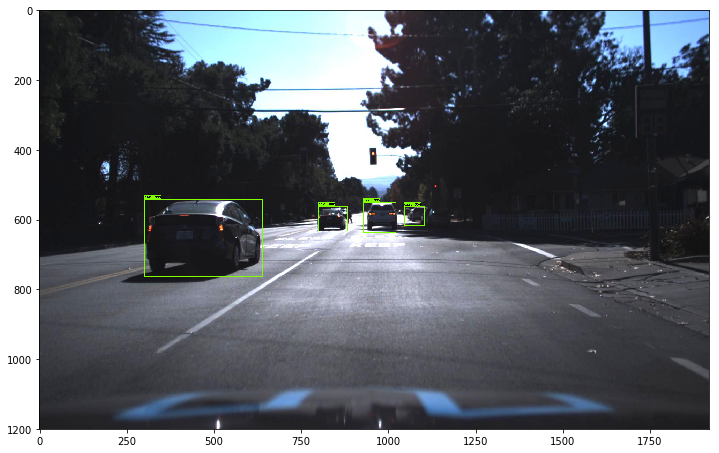

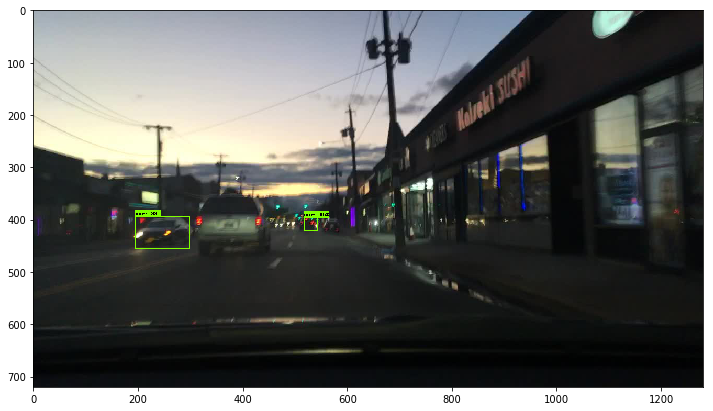

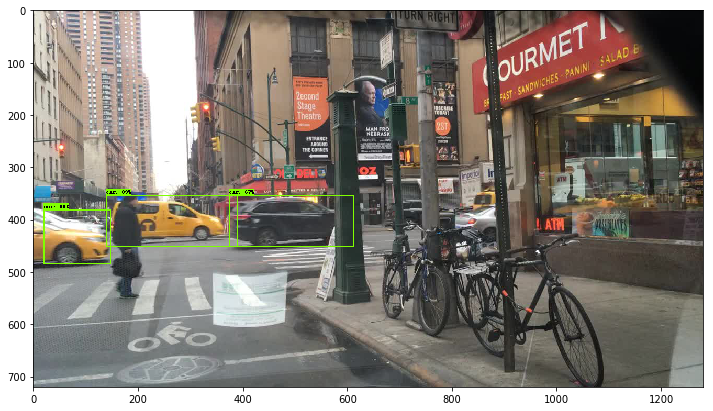

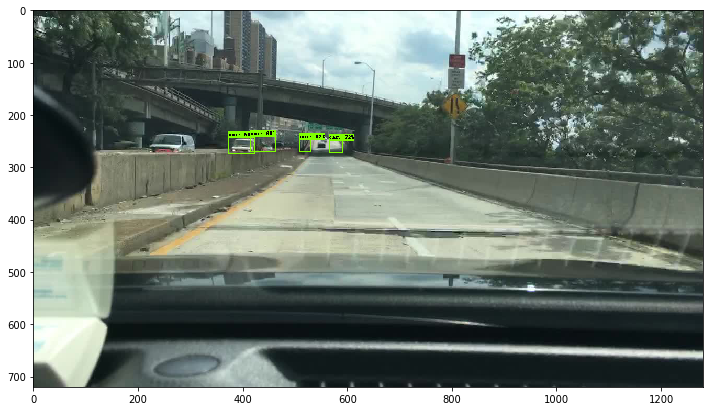

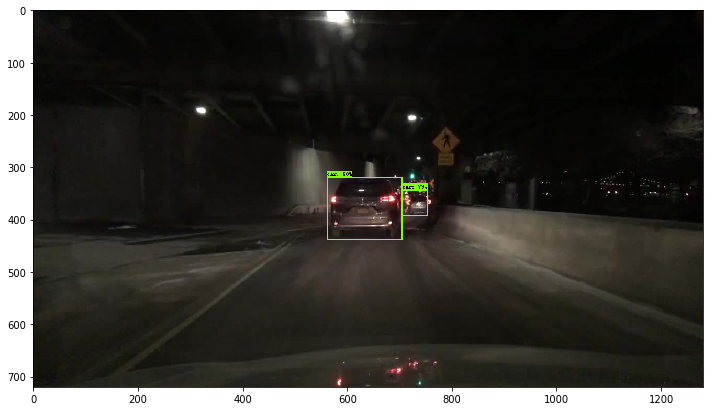

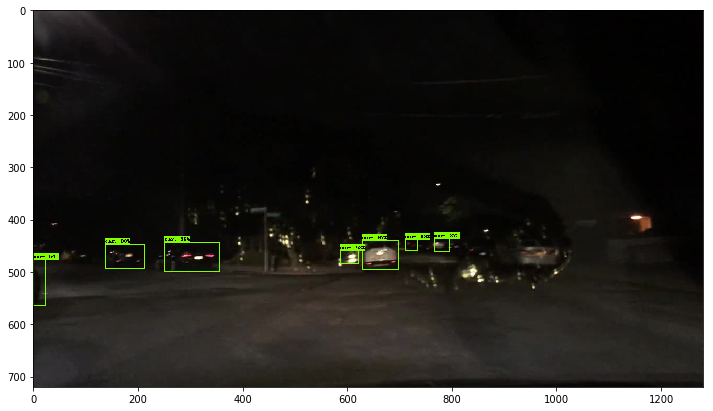

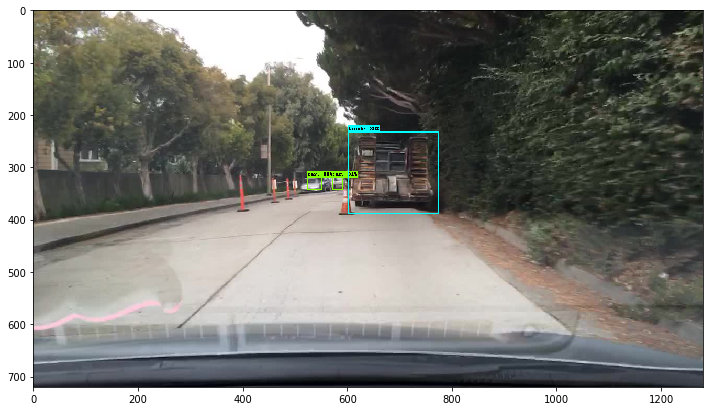

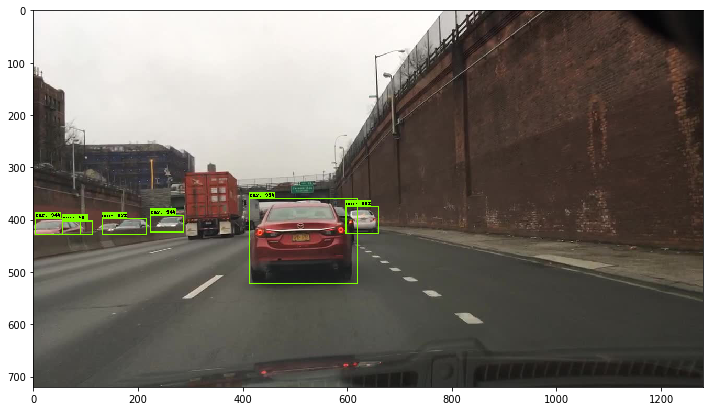

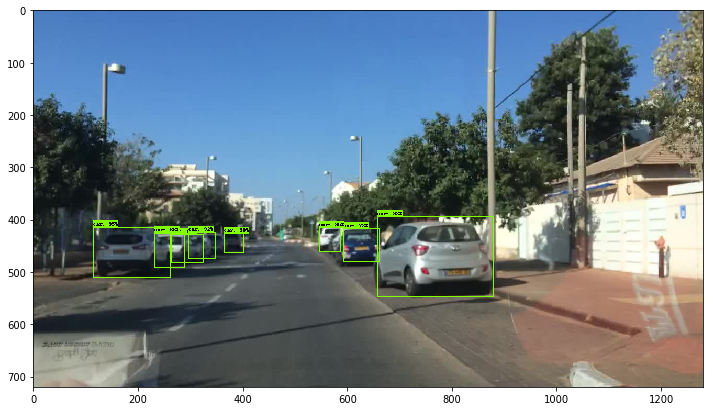

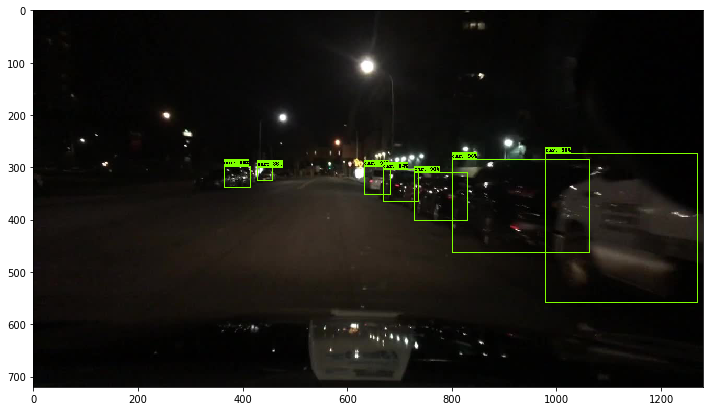

In [18]:
# process images path
DETECTION_RESULT_PATH = os.path.join(CWD_PATH, 'test_images', 'gt', GROUNDTRUTH_PROVIDER, 'output', MODEL_NAME)
DETECTION_RESULT_IMAGE_PATH = os.path.join(DETECTION_RESULT_PATH, 'images')
DETECTION_RESULT_TXT_PATH = os.path.join(DETECTION_RESULT_PATH, 'txt')

print('DETECTION_RESULT_PATH: ', DETECTION_RESULT_PATH)
print('IMAGES COUNT: ', len(IMAGES_LIST))

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        line_thickness = 2
        skip_scores = False
        skip_labels = False
        
        for create_path in [DETECTION_RESULT_IMAGE_PATH, DETECTION_RESULT_TXT_PATH]:
            if not os.path.exists(create_path):
                os.makedirs(create_path)

        for idx, item in enumerate(IMAGES_LIST, 1):
            image_path = os.path.join(TEST_IMAGES_PATH, item)            
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            result_txt_filename = item.replace('.jpg', '.txt').replace('.png', '.txt')
            result_txt_path = os.path.join(DETECTION_RESULT_TXT_PATH, result_txt_filename)
            image_process, count = detect_objects2(image_np, sess, detection_graph, 
                                                  MIN_SCORE_THRESH, line_thickness, skip_scores, skip_labels, result_txt_path)

            #output_image_file = os.path.join(DETECTION_RESULT_PATH, 'images', item)
            #scipy.misc.imsave(output_image_file, image_process)

            if idx % int(len(IMAGES_LIST) / 10) == 0:
                print('[{0:4d}/{1:4d}] image processing'.format(idx, len(IMAGES_LIST)))
                output_image_file = os.path.join(DETECTION_RESULT_PATH, 'images', item)
                scipy.misc.imsave(output_image_file, image_process)
                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_process)
